In [28]:
import numpy as np
import xarray as xr
from typing import Optional, Sequence, Tuple, Union
import tfv.xarray
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

def _auto_vertical_from_layerfaces(
    fv,
    levels: Optional[Sequence[float]] = None,
    band: Optional[float] = None,
    time: Union[int, str, np.datetime64] = 0,
    max_levels: int = 20,
    min_band: float = 0.1,
) -> Tuple[np.ndarray, float]:
    """Infer depth levels (positive downward) and band thickness from `layerface_Z`."""
    ds = fv._obj
    lf = ds["layerface_Z"].sel(Time=time) if "Time" in ds["layerface_Z"].dims else ds["layerface_Z"]
    lf = np.asarray(lf.values).ravel()
    lf = lf[~np.isnan(lf)]
    if lf.size < 2:
        if levels is None:
            levels = np.linspace(0, 10, max(5, max_levels))
        if band is None:
            band = 1.0
        return np.asarray(levels, dtype=float), float(band)

    depths = -lf  # convert height to depth (positive down)
    d_min = float(np.nanpercentile(depths, 5))
    d_max = float(np.nanpercentile(depths, 95))
    levels_auto = np.linspace(max(0.0, d_min), max(0.1, d_max), max_levels)

    dz = np.diff(np.sort(depths))
    dz = dz[~np.isnan(dz)]
    if dz.size == 0:
        est_band = 1.0
    else:
        est_band = float(np.nanpercentile(np.abs(dz), 25))
        if not np.isfinite(est_band) or est_band <= 0.0:
            est_band = float(np.nanmean(np.abs(dz))) if dz.size else 1.0
    est_band = max(est_band, min_band)

    if levels is None:
        levels = levels_auto
    if band is None:
        band = est_band

    return np.asarray(levels, dtype=float), float(band)


def build_3d_regular_grid(
    fv,
    variables: Union[str, Sequence[str]],   # <-- REQUIRED, no default
    times=None,
    dx=0.001, dy=0.001,
    bbox=None,
    levels: Optional[Sequence[float]] = None,
    band: Optional[float] = None,
    max_levels: int = 20,
) -> xr.Dataset:
    """
    Build a 4D regular grid (time, depth, lat/lon or xp/yp) from TFV output.

    Args:
        fv: ds.tfv accessor
        variables: one variable name or a list of names (e.g. "TEMP" or ["SAL","TEMP"])
        times: list of timesteps (ints, datetimes, or strings)
        dx, dy: horizontal resolution
        bbox: (xmin, ymin, xmax, ymax). Defaults to domain extent
        levels: depth levels (positive downward). Auto-inferred if None
        band: thickness for depth averaging. Auto-inferred if None
        max_levels: cap for auto-inferred vertical levels

    Returns:
        xr.Dataset with dims (time, depth, latitude, longitude) or (time, depth, yp, xp)
    """
    # Normalize variables
    if isinstance(variables, str):
        variables = [variables]

    # Handle times
    if times is None:
        times = [fv.Time.values[0]]
    tcoord, tcall = [], []
    for t in times:
        if isinstance(t, (np.datetime64,)):
            tcoord.append(t)
            tcall.append(str(t))
        else:
            t_str = str(t)
            tcall.append(t_str)
            try:
                tcoord.append(np.datetime64(t_str))
            except Exception:
                tcoord.append(fv.Time.values[0])

    # Bounding box
    if bbox is None:
        try:
            xmin, ymin, xmax, ymax = fv.xtr.domain
            bbox = (float(xmin), float(ymin), float(xmax), float(ymax))
        except Exception:
            ds = fv._obj
            x2d = ds["cell_X"].values
            y2d = ds["cell_Y"].values
            bbox = (float(np.nanmin(x2d)), float(np.nanmin(y2d)),
                    float(np.nanmax(x2d)), float(np.nanmax(y2d)))

    # Depth levels
    levels, band = _auto_vertical_from_layerfaces(
        fv, levels=levels, band=band, time=tcoord[0], max_levels=max_levels
    )
    levels = np.asarray(levels)

    # First grid
    g0 = fv.get_sheet_grid(
        time=str(tcall[0]),
        dx=dx, dy=dy, bbox=bbox,
        datum="depth",
        limits=(levels[0] - band/2, levels[0] + band/2),
    )
    if "latitude" in g0:
        yname, xname = "latitude", "longitude"
    else:
        yname, xname = "yp", "xp"

    Y = g0[yname].values
    X = g0[xname].values
    ny, nx = Y.size, X.size

    # Allocate
    data_vars = {var: (("time", "depth", yname, xname),
                       np.full((len(tcoord), len(levels), ny, nx), np.nan, dtype=np.float32))
                 for var in variables}

    # Fill
    for it, t in enumerate(tcall):
        for iz, z0 in enumerate(levels):
            gr = fv.get_sheet_grid(
                time=str(t),
                dx=dx, dy=dy, bbox=bbox,
                datum="depth",
                limits=(z0 - band/2, z0 + band/2),
            )
            for var in variables:
                v = gr[var].values.astype(np.float32)
                if v.shape != (ny, nx):
                    v = gr[var].interp({yname: Y, xname: X}).values.astype(np.float32)
                data_vars[var][1][it, iz, :, :] = v

    # Build Dataset
    ds_out = xr.Dataset(
        data_vars={k: (("time", "depth", yname, xname), v[1]) for k, v in data_vars.items()},
        coords=dict(time=np.array(tcoord), depth=levels, **{yname: Y, xname: X}),
        attrs=dict(
            Origin="3D grid assembled from tfv.get_sheet_grid bands",
            Vertical="depth (positive downward)",
            Band=band,
            Note="Levels/band inferred from layerface_Z unless provided",
        ),
    )
    return ds_out

In [ ]:
model_folder = Path(r'E:/WAMSI/current/')
model_file = 'csiem_B009_20221101_20240401_WQ_20230501_Oneday.nc'

ds = xr.open_dataset(model_folder/model_file, decode_times=True, engine='netcdf4')
# ds_temp = build_3d_regular_grid(ds.tfv, variables="TEMP", times=ds.Time.values)
ds_temp = build_3d_regular_grid(ds.tfv, variables="TEMP", times=[ds.Time[0].values])

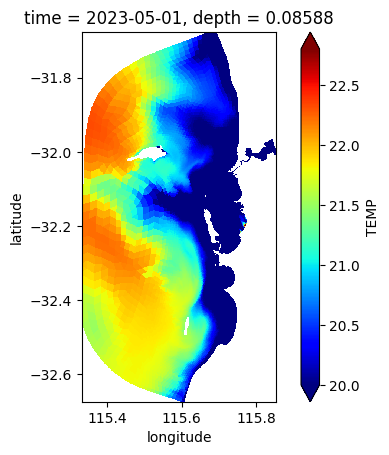

In [19]:
ax = ds_temp.TEMP.isel(time=0, depth=0).plot(vmin=20, vmax=22.8, cmap='jet')
ax.axes.set_aspect('equal')


In [13]:
ds_temp

<xarray.Dataset> Size: 251MB
Dimensions:    (time: 1, depth: 120, latitude: 996, longitude: 524)
Coordinates:
  * time       (time) datetime64[ns] 8B 2023-05-01
  * depth      (depth) float64 960B 0.08588 0.2498 0.4138 ... 19.27 19.43 19.6
  * latitude   (latitude) float64 8kB -32.67 -32.67 -32.67 ... -31.68 -31.68
  * longitude  (longitude) float64 4kB 115.3 115.3 115.3 ... 115.9 115.9 115.9
Data variables:
    TEMP       (time, depth, latitude, longitude) float32 251MB nan nan ... nan
Attributes:
    Origin:    3D grid assembled from tfv.get_sheet_grid bands
    Vertical:  depth (positive downward)
    Band:      0.1
    Note:      Levels/band inferred from layerface_Z unless provided

In [14]:
fv=ds.tfv
time=ds.Time[0].values
grid= fv.get_sheet_grid(
    variables="TEMP",
    time= time,
    dx=0.001,        # horizontal resolution
    dy=0.001,        # vertical resolution
    datum='depth',
    limits=(0, 0.1)  # example limits, adjust as needed
)
grid
    

<xarray.Dataset> Size: 4MB
Dimensions:    (time: 1, latitude: 996, longitude: 524)
Coordinates:
  * time       (time) datetime64[ns] 8B 2023-05-01
  * latitude   (latitude) float64 8kB -32.67 -32.67 -32.67 ... -31.68 -31.68
  * longitude  (longitude) float64 4kB 115.3 115.3 115.3 ... 115.9 115.9 115.9
Data variables:
    TEMP       (time, latitude, longitude) float64 4MB nan nan nan ... nan nan
Attributes:
    Origin:       2D Grid extracted from TUFLOW FV cell-centered output using...
    Type:         2D Grid from TUFLOW FV output
    Datum:        depth
    Limits:       (0, 0.1)
    Agg:          mean
    Grid method:  nearest

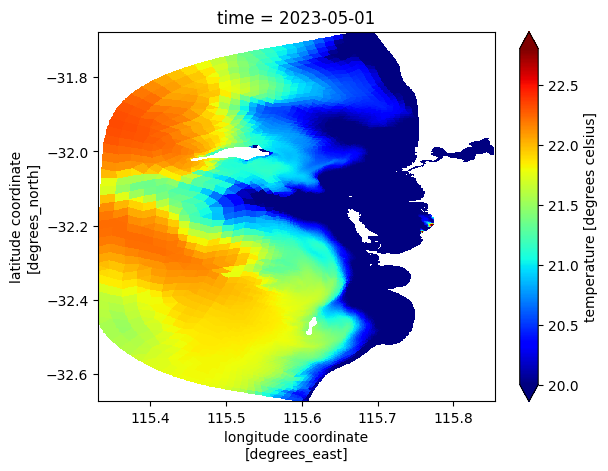

In [15]:
grid.TEMP.plot(vmin=20, vmax=22.8, cmap='jet')

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


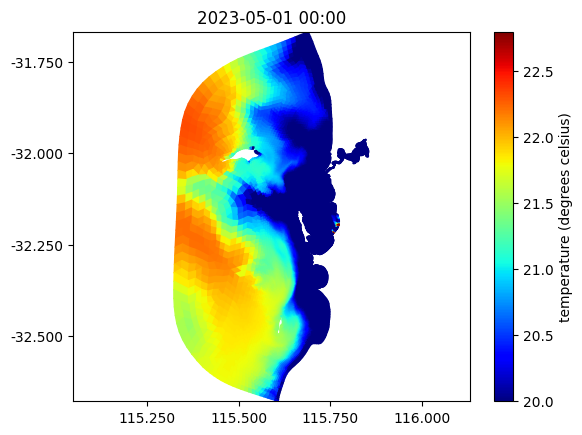

In [16]:
fv.plot('TEMP', time=time, cmap='jet', clim=(20, 22.8), datum='depth', limits=(0, 0.1))

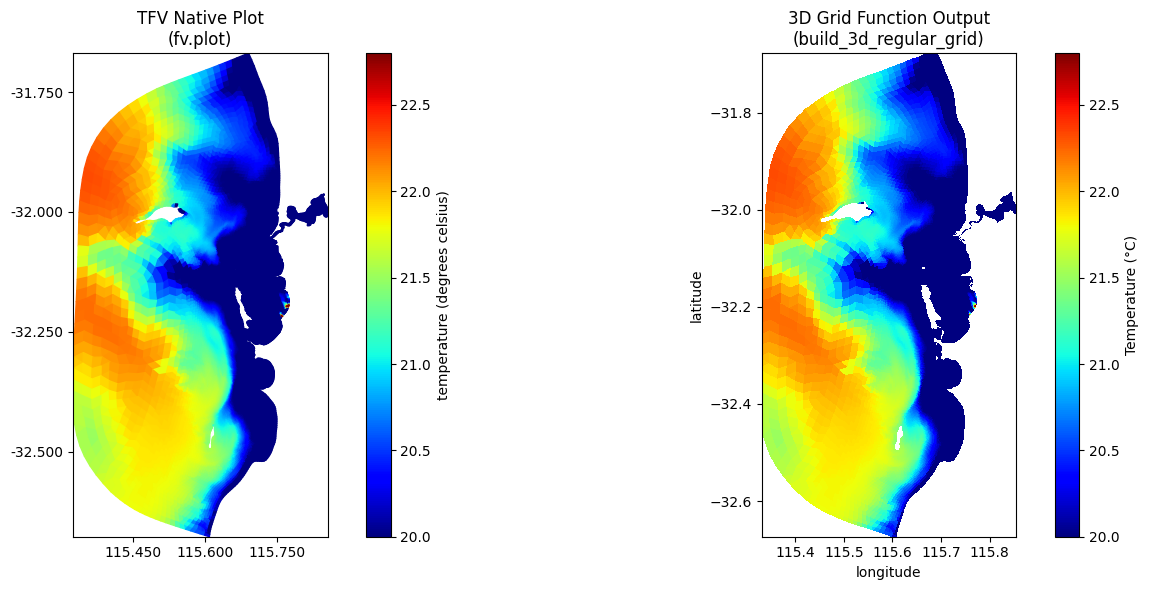

In [20]:
# Side-by-side comparison: tfv.plot vs 3D function output
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Left plot: tfv.plot (native TFV plotting)
fv.plot('TEMP', time=time, cmap='jet', clim=(20, 22.8), datum='depth', limits=(0, 0.1), ax=ax1)
ax1.set_title('TFV Native Plot\n(fv.plot)')
ax1.set_aspect('equal')

# Right plot: 3D function output
im = ds_temp.TEMP.isel(time=0, depth=0).plot(ax=ax2, vmin=20, vmax=22.8, cmap='jet', add_colorbar=False)
ax2.set_title('3D Grid Function Output\n(build_3d_regular_grid)')
ax2.set_aspect('equal')

# Add colorbar for the right plot
plt.colorbar(im, ax=ax2, label='Temperature (°C)')

plt.tight_layout()
plt.show()

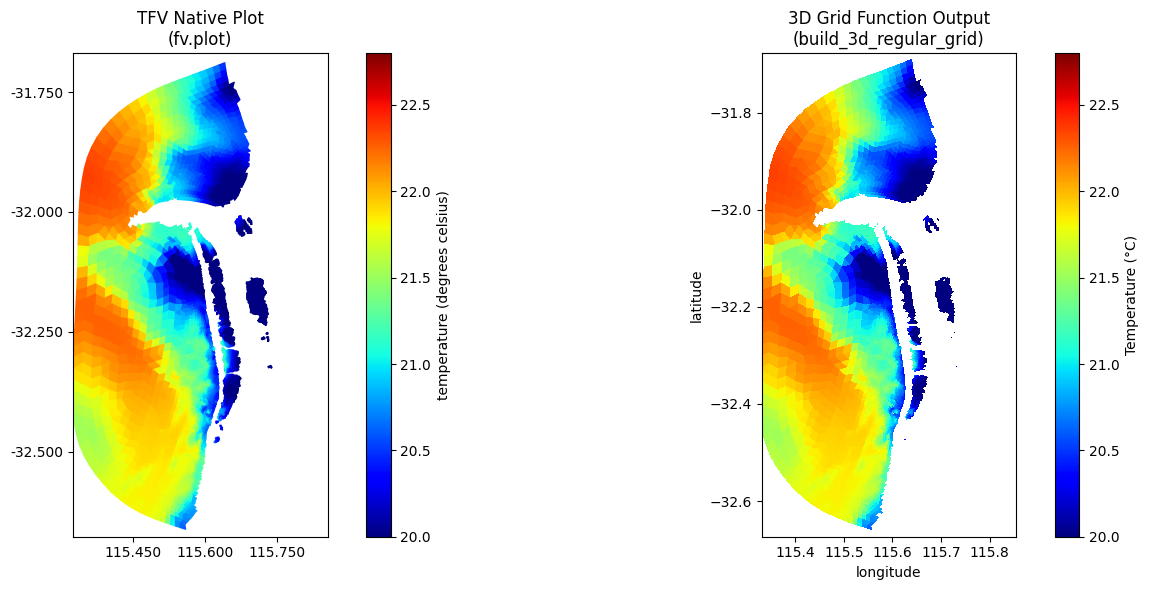

In [23]:
# Side-by-side comparison: tfv.plot vs 3D function output
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Left plot: tfv.plot (native TFV plotting)
fv.plot('TEMP', time=time, cmap='jet', clim=(20, 22.8), datum='depth', limits=(19.50, 19.58), ax=ax1)
ax1.set_title('TFV Native Plot\n(fv.plot)')
ax1.set_aspect('equal')

# Right plot: 3D function output
im = ds_temp.TEMP.isel(time=0, depth=-1).plot(ax=ax2, vmin=20, vmax=22.8, cmap='jet', add_colorbar=False)
ax2.set_title('3D Grid Function Output\n(build_3d_regular_grid)')
ax2.set_aspect('equal')

# Add colorbar for the right plot
plt.colorbar(im, ax=ax2, label='Temperature (°C)')

plt.tight_layout()
plt.show()